In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import deepcopy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from funcs import *
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error
from rasterio import mask as msk
import pandas as pd
import scipy.io
from model import *

In [ ]:
with open('./auto_data/Kronebreen_auto_1420_it_parameters.p_friction_1000_it_fields.vel_mes_it_parameters.pmax_5000__0.pkl', 'rb') as inp:
    md = pickle.load(inp)

In [4]:
print(md.warnings)

[]


Text(0.5, 1.0, 'Bed deviation compared to initial bed vs iter')

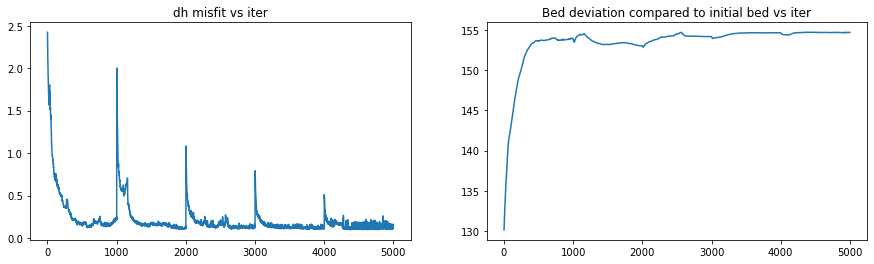

In [5]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
line = ax[0].plot(md.series.dh_misfit_vs_iter)
line = ax[1].plot(md.series.B_misfit_vs_iter)
ax[0].set_title('dh misfit vs iter')
ax[1].set_title('Bed deviation compared to initial bed vs iter')
#ax[0].set_ylim([0,5])

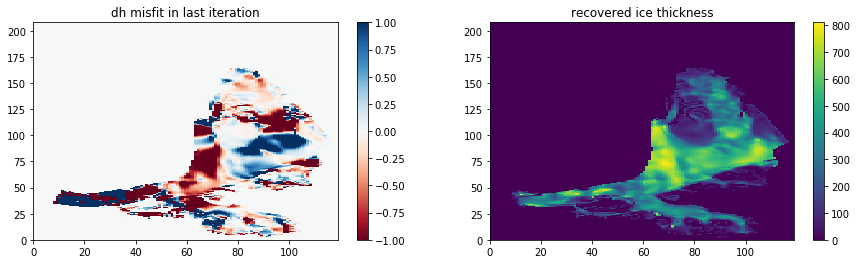

In [5]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
field = ax[0].pcolor(md.series.misfit_all[-1]*md.it_fields.mask, vmin = -1, vmax = 1, cmap='RdBu')
field1 = ax[1].pcolor(md.it_fields.S_ref-md.series.B_rec_all[-1])
ax[0].set_title('dh misfit in last iteration')
ax[1].set_title('recovered ice thickness')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

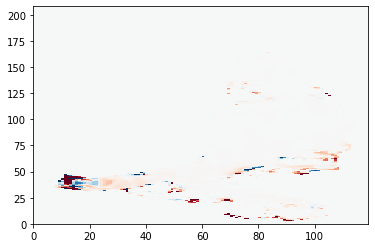

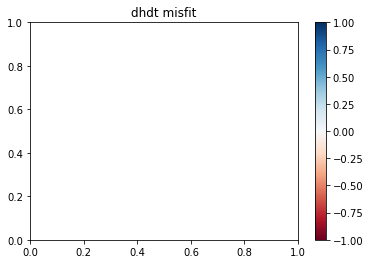

In [9]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots()
for i in range(0,len(md.series.B_rec_all),30):
    field = axes.pcolor(md.series.misfit_all[i], cmap='RdBu', vmin=-1, vmax=1)
    #field = axes.pcolor(md.series.S_rec_all[i]-md.series.B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

(-100, 100)

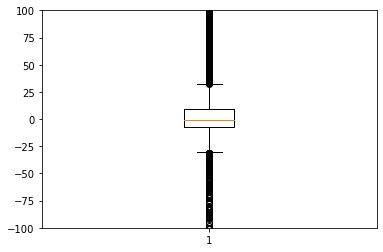

In [205]:
fig, ax = plt.subplots()
box = ax.boxplot((np.maximum(md.series.vel_all[-1].data,0)-md.it_fields.vel_mes)[data.mask_Kr==1].flatten())
ax.set_ylim([-100,100])

In [10]:
flow_dir_mod = np.zeros_like(md.it_fields.S_ref)
flow_dir_mod_rad = np.zeros_like(md.it_fields.S_ref)
vel_ratio = np.zeros_like(md.it_fields.S_ref)
for i in range(np.shape(md.it_fields.S_ref)[0]):
    for j in range(np.shape(md.it_fields.S_ref)[1]):
        if abs(md.it_products.u_mod.data[i,j])<1e-2:
            if abs(md.it_products.v_mod.data[i,j])<1e-2:
                vel_ratio[i,j]=np.nan
            elif md.it_products.v_mod.data[i,j]<0:
                flow_dir_mod[i,j]=0
            elif md.it_products.v_mod.data[i,j]>0:
                flow_dir_mod[i,j]=180
        else:
            vel_ratio[i,j] = md.it_products.v_mod.data[i,j] / md.it_products.u_mod.data[i,j]
        if md.it_products.u_mod.data[i,j] > 0:
            flow_dir_mod[i,j] = 90-np.degrees(np.arctan(vel_ratio[i,j]))
        if md.it_products.u_mod.data[i,j] < 0:
            flow_dir_mod[i,j] = 270-np.degrees(np.arctan(vel_ratio[i,j]))
        flow_dir_mod_rad[i,j] = np.arctan(vel_ratio[i,j])

In [14]:
flow_dir_mes = np.zeros_like(md.it_fields.S_ref)
flow_dir_mes_rad = np.zeros_like(md.it_fields.S_ref)
vel_ratio = np.zeros_like(md.it_fields.S_ref)
for i in range(np.shape(md.it_fields.S_ref)[0]):
    for j in range(np.shape(md.it_fields.S_ref)[1]):
        if abs(data.vx_Adrian[i,j])<1e-2:
            if abs(data.vy_Adrian[i,j])<1e-2:
                vel_ratio[i,j]=np.nan
            elif data.vy_Adrian[i,j]<0:
                flow_dir_mes[i,j]=0
            elif data.vy_Adrian[i,j]>0:
                flow_dir_mes[i,j]=180
        else:
            vel_ratio[i,j] = data.vy_Adrian[i,j] / data.vx_Adrian[i,j]
        if data.vx_Adrian[i,j] > 0:
            flow_dir_mes[i,j] = 90-np.degrees(np.arctan(vel_ratio[i,j]))
        if data.vx_Adrian[i,j] < 0:
            flow_dir_mes[i,j] = 270-np.degrees(np.arctan(vel_ratio[i,j]))
        flow_dir_mes_rad[i,j] = np.arctan(vel_ratio[i,j])
            
flow_dir_diff = np.zeros_like(md.it_fields.S_ref)
for i in range(np.shape(md.it_fields.S_ref)[0]):
    for j in range(np.shape(md.it_fields.S_ref)[1]):
        if np.sign(data.vx_Adrian[i,j]) == np.sign(md.it_products.u_mod[i,j]):
            flow_dir_diff[i,j] = flow_dir_mod_rad[i,j] - flow_dir_mes_rad[i,j]
        elif np.sign(data.vx_Adrian[i,j]) != np.sign(md.it_products.u_mod[i,j]):
            flow_dir_diff[i,j] = np.pi - flow_dir_mod_rad[i,j] + flow_dir_mes_rad[i,j]
        

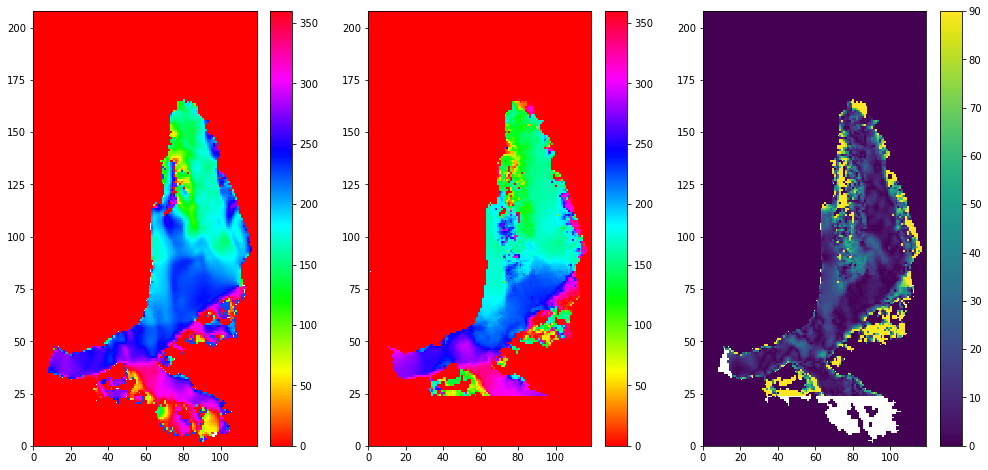

In [15]:
fig, ax = plt.subplots(1,3, figsize = (17,8))
field = ax[0].pcolor(flow_dir_mod*data.mask_Kr, vmin = 0, vmax = 360, cmap='hsv')
field1 = ax[1].pcolor(flow_dir_mes*data.mask_Kr, vmin = 0, vmax = 360, cmap='hsv')
field2 = ax[2].pcolor(abs(np.degrees(flow_dir_diff))*data.mask_Kr, vmin = 0, vmax = 90)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])
fig.colorbar(field2, ax = ax[2])

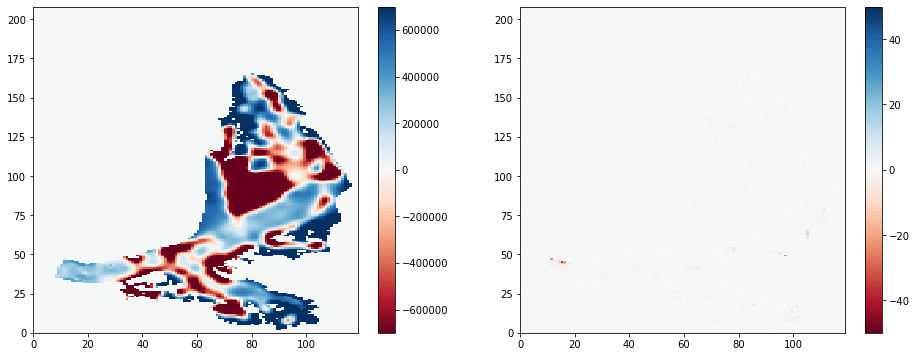

In [15]:
nc_field = 'velsurf_mag'
fig, ax = plt.subplots(1,2,figsize = (16,6))
field = ax[0].pcolor((md.series.tauc_recs[0]-md.series.tauc_recs[-1])*data.mask_Kr, vmin = -7e5, vmax = 7e5, cmap='RdBu')
#field1 = ax[1].pcolor((md.it_products.vel_mismatch)*data.mask_Kr, cmap='RdBu', vmin = -.5, vmax=.5)
field1 = ax[1].pcolor((md.series.B_rec_all[-1] - md.series.B_rec_all[-350])*data.mask_Kr,cmap='RdBu', vmin = -50, vmax=50)
#field1 = ax[1].pcolor((bla)*np.minimum(md.it_fields.vel_mes,1)*md.it_fields.mask, cmap='RdBu', vmin = -.5, vmax=.5)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

/home/thomas/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


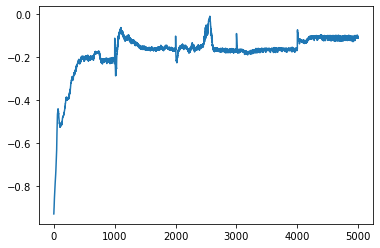

In [13]:
vel_ser = []
for i in range(len(md.series.B_rec_all)):
    vel_ser.append(np.median(((md.series.vel_all[i]-md.it_fields.vel_mes)/md.it_fields.vel_mes)[np.logical_and(data.mask_Kr==1, data.x<455000)]))
    
plt.plot(vel_ser)

(40, 150)

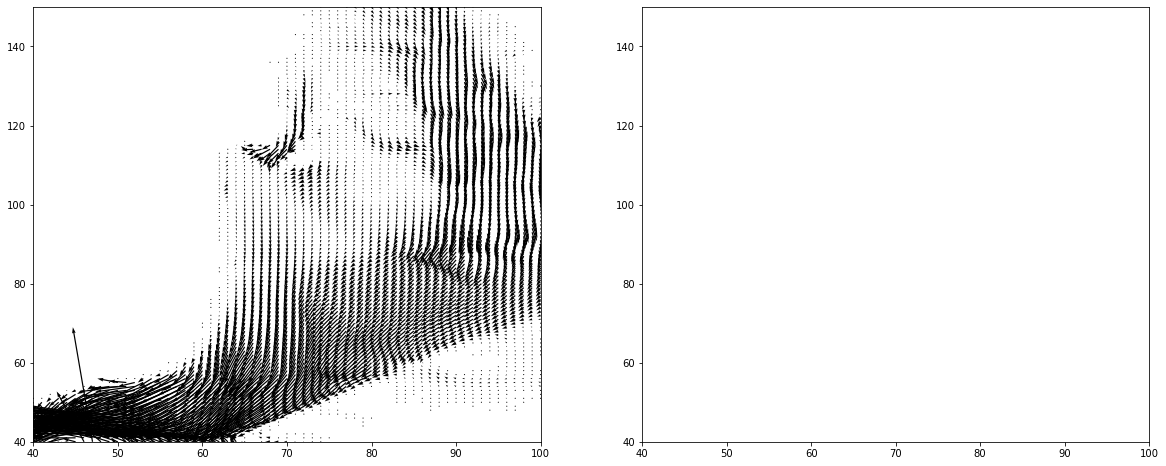

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
field = ax[0].quiver(md.it_products.u_mod*md.it_fields.mask, md.it_products.v_mod*md.it_fields.mask, scale=2e3)
field1 = ax[1].quiver(data.vx_Adrian*md.it_fields.mask, data.vy_Adrian*md.it_fields.mask, scale=2e3)
ax[0].set_xlim([40,100])
ax[1].set_xlim([40,100])
ax[0].set_ylim([40,150])
ax[1].set_ylim([40,150])

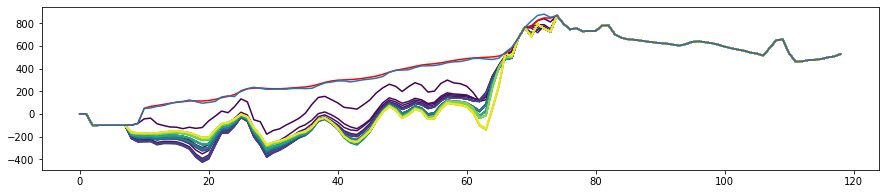

In [12]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(md.series.B_rec_all))]
fig, ax = plt.subplots(figsize=(15,3))
for i in range(0,len(md.series.B_rec_all),100):
    lines = ax.plot((md.series.B_rec_all[i])[42,:], color = colors[i])
lines = ax.plot((md.series.S_rec_all[-1])[42,:], color = 'r')
#line = ax.plot(((md.it_products.h_rec+md.it_fields.B_rec)*md.it_fields.mask)[40,:], 'b')
line = ax.plot((md.it_fields.S_ref)[42,:])

In [6]:
data = input_data()
data.build_input()

radar = radar_data()
radar.rad_as_array(data)

Text(0.5, 1.0, 'measured vs calculated bed elevation')

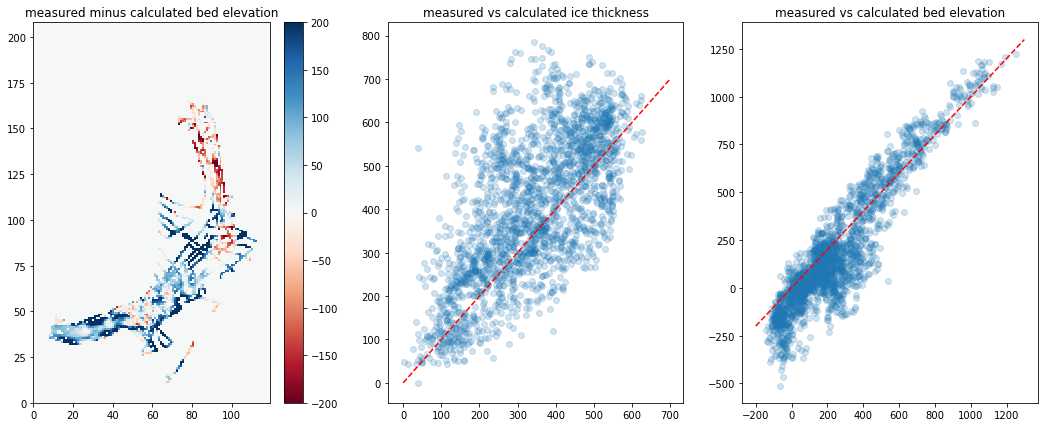

In [7]:
it_step = -1
fig, ax = plt.subplots(1,3, figsize=(18,7))
field = ax[0].pcolor(((md.series.S_rec_all[it_step]-md.series.B_rec_all[it_step])-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 200, vmin = -200, cmap='RdBu')
fig.colorbar(field, ax = ax[0])

line = ax[1].plot(range(700), range(700), '--', c='r')
scatter = ax[1].scatter((md.it_fields.S_ref-radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], (md.it_fields.S_ref-md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2)
#scatter = ax[1].scatter((md.it_fields.S_ref-radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], (md.it_fields.S_ref-md.series.B_rec_all[499])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2, c='r')

scatter = ax[2].scatter(radar.bed_arr[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], md.series.B_rec_all[it_step][np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)], marker='o', alpha=.2)
line = ax[2].plot(range(-200, 1300), range(-200, 1300), '--', c='r')

ax[0].set_title('measured minus calculated bed elevation')
ax[1].set_title('measured vs calculated ice thickness')
ax[2].set_title('measured vs calculated bed elevation')

In [8]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
thick_ref_at_rad = (md.it_fields.S_ref - radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
thick_rec_at_rad = (md.series.S_rec_all[it_step] - md.series.B_rec_all[it_step])[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
dev = (thick_rec_at_rad - thick_ref_at_rad)/280
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec_at_rad - thick_ref_at_rad))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
#conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
conf_dev = (np.nanpercentile(dev, 5), np.nanpercentile(dev, 95))
RMSE = math.sqrt(mean_squared_error(thick_ref_at_rad, thick_rec_at_rad))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}%'.format(IQR_dev))
print('95% confidence intervall: {}%'.format(conf_dev))

RMSE: 144.4409650976401 m
mean deviation: 0.2512388504117479 %
mean absolute deviation: 111.56843081518835 m
median deviation: 0.2287934751393009 %
Interquartile range of deviation: 0.5532371188928821%
95% confidence intervall: (-0.4581666204333073, 1.0903094317477895)%


In [9]:
dev_all = []
mean_dev_all = []
mean_abs_dev_all = []
med_dev_all = []
IQR_dev_all = []
conf_dev_all = []
RMSE_all = []
thick_ref = (md.it_fields.S_ref - radar.bed_arr)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
for i in range(len(md.series.B_rec_all)):
    thick_rec = (md.it_fields.S_ref - md.series.B_rec_all[i].data)[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
    dev_all.append((thick_rec - thick_ref)/280)
    mean_dev_all.append(np.nanmean((dev_all)))
    mean_abs_dev_all.append(np.nanmean(abs(thick_rec - thick_ref)))
    med_dev_all.append(np.nanmedian(dev_all[i]))
    IQR_dev_all.append(np.nanpercentile(dev_all[i], 75) - np.nanpercentile(dev_all[i], 25))
    conf_dev_all.append(np.nanpercentile(dev_all[i], 95) - np.nanpercentile(dev_all[i], 5))
    RMSE_all.append(math.sqrt(mean_squared_error(thick_ref, thick_rec)))

Text(0.5, 1.0, 'RMSE of deviation')

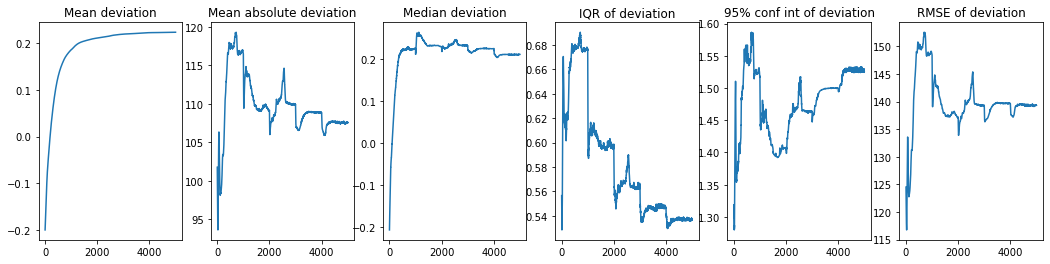

In [10]:
fig, ax = plt.subplots(1,6, figsize=(18,4))
line1 = ax[0].plot(mean_dev_all)
line2 = ax[1].plot(mean_abs_dev_all)
line3 = ax[2].plot(med_dev_all)
line4 = ax[3].plot(IQR_dev_all)
line5 = ax[4].plot(conf_dev_all)
line6 = ax[5].plot(RMSE_all)
ax[0].set_title('Mean deviation')
ax[1].set_title('Mean absolute deviation')
ax[2].set_title('Median deviation')
ax[3].set_title('IQR of deviation')
ax[4].set_title('95% conf int of deviation')
ax[5].set_title('RMSE of deviation')

Text(0.5, 1.0, 'percent deviation relative to stake velocities between stake and ITS_LIVE velocities')

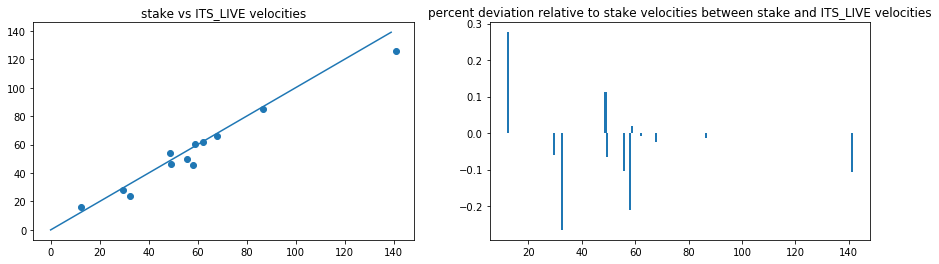

In [16]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel('./kronebreen/HDF_stake_velocities.xlsx', 0, header=None)
vel_1420 = np.nanmean(np.array(vel_df.loc[3:,range(20,30,2)]), axis=1)
vel_mes_at_stakes = get_nearest(data.x,data.y,md.it_fields.vel_mes, vel_x, vel_y)
fig,ax = plt.subplots(1,2, figsize = (15,4))
points = ax[0].scatter(vel_1420, vel_mes_at_stakes)
line = ax[0].plot(range(140), range(140))
points1 = ax[1].bar(vel_1420, (vel_mes_at_stakes  - vel_1420)/vel_1420)

ax[0].set_title('stake vs ITS_LIVE velocities')
ax[1].set_title('percent deviation relative to stake velocities between stake and ITS_LIVE velocities')

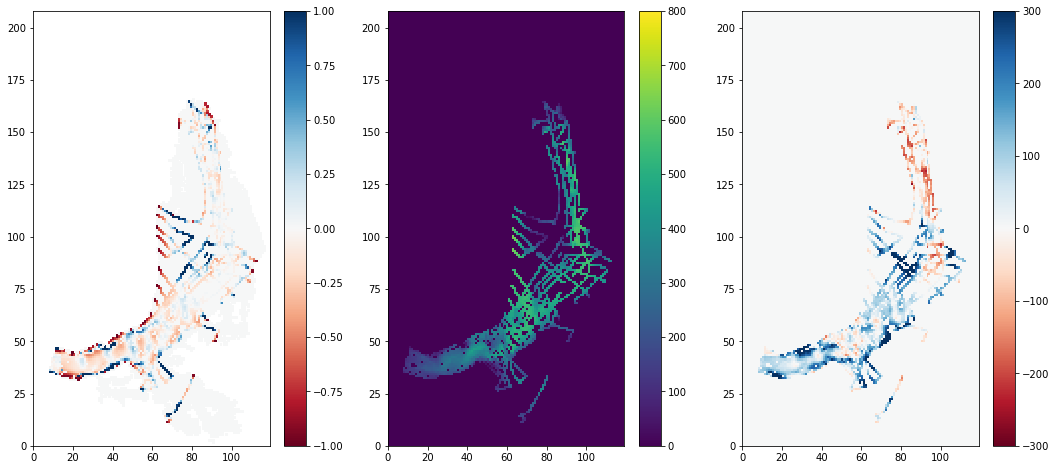

In [16]:
fig,ax = plt.subplots(1,3,figsize = (18,8))
field = ax[0].pcolor((md.series.vel_all[it_step]-data.vel_Adrian)/data.vel_Adrian*radar.mask_arr*np.minimum(md.it_fields.vel_mes,1), cmap = 'RdBu', vmin = -1, vmax = 1)
field1 = ax[1].pcolor((md.it_fields.S_ref - radar.bed_arr)*radar.mask_arr*md.it_fields.mask, vmax = 800, vmin = 0)
field2 = ax[2].pcolor(((md.it_fields.S_rec - md.it_fields.B_rec)-(md.it_fields.S_ref - radar.bed_arr))*radar.mask_arr*md.it_fields.mask, vmax = 300, vmin = -300, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])
fig.colorbar(field2, ax = ax[2])

In [34]:
vel = ((md.series.vel_all[it_step]-md.it_fields.vel_mes))[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
rad = ((md.it_fields.S_ref-radar.bed_arr) - (md.it_fields.S_ref-md.series.B_rec_all[it_step]))[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]
flow = abs(np.degrees(flow_dir_diff[np.logical_and(radar.mask_arr==1, md.it_fields.mask==1)]))

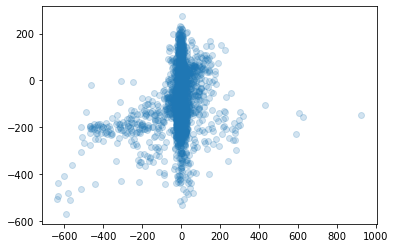

In [36]:
fig, ax = plt.subplots()
points = ax.scatter(vel,rad, alpha=.2)
#ax.set_xlim([0,2])
#ax.set_ylim([0,30])

In [27]:
y_sub, x_sub = np.ogrid[:np.shape(md.it_fields.S_ref)[0]/4,:np.shape(md.it_fields.S_ref)[1]/4]
y_sub *= 4
x_sub *= 4
x_sub = zoom(data.x, .25)
y_sub = zoom(data.y, .25)
thick_ref = (scipy.interpolate.griddata((radar.x_arr[radar.mask_arr==1].flatten() , radar.y_arr[radar.mask_arr==1].flatten()), (md.it_fields.S_ref - radar.bed_arr)[radar.mask_arr==1].flatten(), (zoom(data.x, 1).flatten(), zoom(data.y, 1).flatten()))).reshape(np.shape(zoom(data.x, 1)))
#thick_ref[np.isnan(thick_ref)] = 0
#thick_ref = zoom(thick_ref, 4)[:,:119]
#thick_ref[thick_ref<10] = np.nan
#plt.scatter(x_sub, y_sub, c = np.unique(radar_sub))
#scripy.interpolate.griddata()

In [28]:
import scipy.stats as st
thick_rec = (md.it_fields.S_rec - md.it_fields.B_rec)
dev = ((thick_rec - thick_ref)/np.nanmean(thick_ref))[np.logical_and(data.mask_Kr==1, thick_rec!=0)]
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec - thick_ref)[np.logical_and(data.mask_Kr==1, thick_rec!=0)])
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
#conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
conf_dev = (np.nanpercentile(dev, 5), np.nanpercentile(dev, 95))
RMSE = math.sqrt(mean_squared_error(thick_ref[np.logical_and(np.logical_and(data.mask_Kr==1, thick_rec!=0), np.isnan(thick_ref)==False)], thick_rec[np.logical_and(np.logical_and(data.mask_Kr==1, thick_rec!=0), np.isnan(thick_ref)==False)]))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}%'.format(IQR_dev))
print('95% confidence intervall: {}%'.format(conf_dev))

RMSE: 142.14496189295076 m
mean deviation: 0.09242059167900206 %
mean absolute deviation: 112.3093976872027 m
median deviation: 0.09115346939955793 %
Interquartile range of deviation: 0.6099245785795996%
95% confidence intervall: (-0.7322478088420207, 0.8448280830089904)%


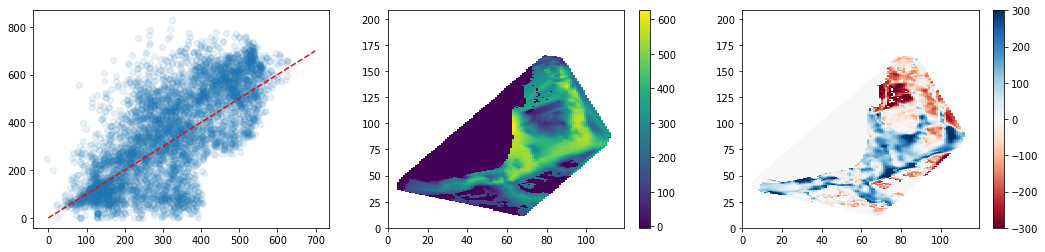

In [29]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
points = ax[0].scatter(thick_ref[np.logical_and(data.mask_Kr==1, thick_rec!=0)], (md.it_fields.S_rec - md.it_fields.B_rec)[np.logical_and(data.mask_Kr==1, thick_rec!=0)], alpha=0.1)
line = ax[0].plot(range(700), range(700), '--',c='r')
field = ax[1].pcolor(thick_ref*data.mask_Kr)
field1 = ax[2].pcolor((thick_rec - thick_ref)*data.mask_Kr, cmap='RdBu', vmin = -300, vmax = 300)
fig.colorbar(field, ax = ax[1])
fig.colorbar(field1, ax = ax[2])

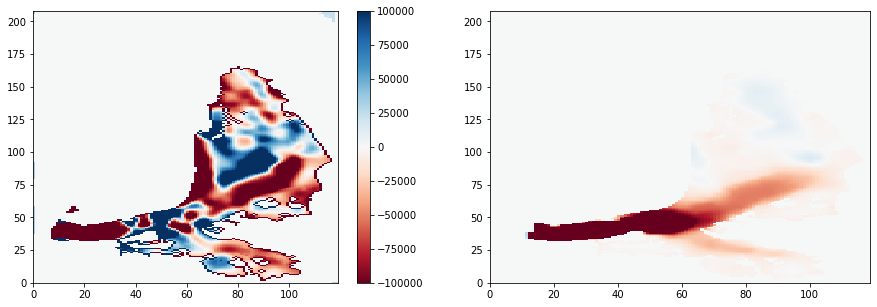

In [18]:
u = md.it_products.u_mod
v = md.it_products.v_mod
vel = md.it_products.vel_mod

fig, ax = plt.subplots(1,2, figsize=(15,5))
field = ax[0].pcolor(md.series.tauc_recs[-1]-md.series.tauc_recs[450], cmap='RdBu', vmin = -1e5, vmax=1e5)
field1= ax[1].pcolor(data.vx_Jack*365*3.2*data.mask_Kr, cmap='RdBu', vmin = -100, vmax = 100)
fig.colorbar(field, ax = ax[0])

In [2]:
data = input_data()
data.build_input()
md = model(data)
md.it_parameters.pmax=300
md.it_fields.vel_mes = data.vel_Jack
md.it_parameters.p_friction = 150
md.iterate(data)

/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


15


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


16


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


17


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


18


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


19


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


20


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


21


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


22


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


23


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


24


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


25


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


26


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


27


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


28


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


29


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


30


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


31


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


32


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


33


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


34


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


35


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


36


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


37


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


38


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


39


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


40


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


41


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


42


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


43


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


44


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


45


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


46


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


47


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


48


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


49


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


50


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


51


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


52


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


53


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


54


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


55


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


56


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


57


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


58


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


59


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


60


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


61


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


62


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


63


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


64


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


65


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


66


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


67


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


68


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


69


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


70


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


71


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


72


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


73


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


74


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


75


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


76


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


77


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


78


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


79


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


80


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


81


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


82


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


83


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


84


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


85


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


86


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


87


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


88


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


89


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


90


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


91


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


92


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


93


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


94


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


95


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


96


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


97


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


98


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


99


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


100


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


101


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


102


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


103


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


104


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


105


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


106


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


107


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


108


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


109


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


110


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


111


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


112


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


113


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


114


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


115


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


116


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


117


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


118


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


119


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


120


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


121


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


122


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


123


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


124


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


125


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


126


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


127


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


128


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


129


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


130


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


131


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


132


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


133


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


134


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


135


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


136


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


137


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


138


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


139


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


140


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


141


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


142


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


143


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


144


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


145


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


146


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


147


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


148


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


149


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


150


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data
/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


151


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


152


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


153


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


154


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


155


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


156


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


157


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


158


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


159


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


160


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


161


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


162


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


163


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


164


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


165


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


166


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


167


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


168


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


169


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


170


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


171


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


172


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


173


KeyboardInterrupt: 

In [70]:
#ref_file = './auto_ncs/KK_auto_reference_it490.nc'
#md.series.S_rec_all.append(get_nc_data(ref_file, 'usurf', 0))
#md.series.B_rec_all.append(get_nc_data(ref_file, 'topg', 0))
#md.series.tauc_recs.append(get_nc_data(ref_file, 'tauc', 0))
#md.series.B_rec_all[-1] = np.minimum(md.series.B_rec_all[-1], md.series.S_rec_all[-1])
md.it_fields.vel_mes = data.vel_Adrian
md.it_parameters.p_friction = 10000
md.it_parameters.pmax= 50
md.series.B_rec_all[450] = np.minimum(md.series.B_rec_all[450], md.series.S_rec_all[-1])
md.restart(450)
md.it_parameters.p_friction = 10
md.it_parameters.pmax = 15
md.restart(-1)
md.it_parameters.p_friction = 3000
md.it_parameters.pmax = 300
md.restart(-1)

0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


15


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


16


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


17


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


18


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


19


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


20


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


21


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


22


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


23


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


24


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


25


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


26


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


27


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


28


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


29


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


30


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


31


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


32


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


33


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


34


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


35


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


36


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


37


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


38


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


39


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


40


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


41


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


42


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


43


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


44


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


45


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


46


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


47


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


48


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


49


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


8


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


9


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


10


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data
/home/thomas/pism-stable/thick_inv/model.py:496: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


11


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


12


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


13


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


14


--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpiexec detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[64206,1],0]
  Exit code:    1
--------------------------------------------------------------------------
/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


0


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


1


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


2


--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpiexec detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[64307,1],0]
  Exit code:    1
--------------------------------------------------------------------------
/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


3


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


4


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


5


--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpiexec detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[62821,1],3]
  Exit code:    1
--------------------------------------------------------------------------
/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


6


/home/thomas/pism-stable/thick_inv/funcs.py:114: RuntimeWarning: invalid value encountered in sqrt
  uv_mag = np.sqrt(u**2+v**2).data


7


KeyboardInterrupt: 

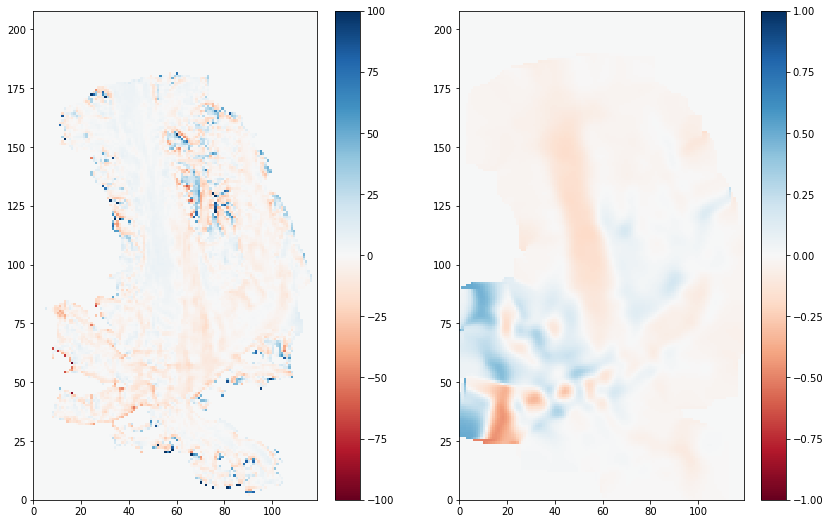

In [22]:
fig,ax = plt.subplots(1,2, figsize = (14,9))
field = ax[0].pcolor((md.it_fields.S_ref - md.it_fields.S_rec)*md.it_fields.mask, vmax =-100, vmin = 100, cmap='RdBu')
field1 = ax[1].pcolor(md.it_products.vel_mismatch, vmax =-1, vmin = 1, cmap='RdBu')
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

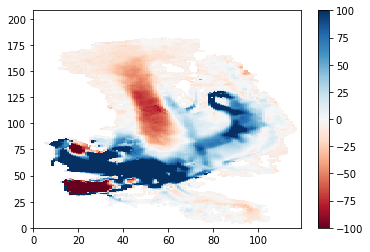

In [8]:
fig, ax = plt.subplots()
#field = ax.pcolor(get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velsurf_mag',0),vmax=1000)
field = ax.pcolor(md.it_products.vel_mod-data.vel_Adrian, cmap = 'RdBu', vmin = -100, vmax = 100)
fig.colorbar(field, ax = ax)

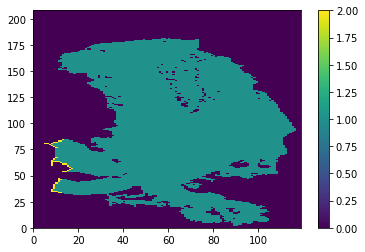

In [4]:
fig,ax = plt.subplots()
field = ax.pcolor(data.mask+data.contact_zone)#, vmin = 0, vmax = 90)
fig.colorbar(field, ax = ax)

In [36]:
data1 = input_data()
DEM_VEL_mat = scipy.io.loadmat('./kronebreen/HDF_2021_10_06.mat')['HDF'][0,0]
data1.set_xy(DEM_VEL_mat)
data1.reset_shape()
data1.import_NPI_DEM("./kronebreen/S0_DTM50.tif")
data1.get_vel(DEM_VEL_mat)
data1.get_outlines('./kronebreen/rgi_outlines/07_rgi60_Svalbard.shp')
data1.get_dhdt(DEM_VEL_mat)
data1.get_mask()
#data1.clean_dhdt()
data1.get_vel_Adrian()
#data1.resample_input()

In [37]:
with rasterio.open('./kronebreen/S0_DTM50.tif') as src:
    profile = src.profile.copy()
    profile1 = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a  * 5, aff.b, aff.c+data.window.col_off*50,
                             aff.d, aff.e * 5, aff.f-data.window.row_off*50)

    newaff1 = rasterio.Affine(aff.a, aff.b, aff.c+data.window.col_off*50,
                             aff.d, aff.e, aff.f-data.window.row_off*50)
    profile.update({
            'dtype': 'float32',
            'height':md.it_fields.B_rec.shape[0],
            'width':md.it_fields.B_rec.shape[1],
            'transform': newaff}) 
    profile1.update({
            'dtype': 'float32',
            'height':data1.mask.shape[0],
            'width':data1.mask.shape[1],
            'transform': newaff1}) 
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/B_rec.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(md.it_fields.B_rec, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/dhdt.tif', 'w', **profile) as dst:
    dhdt_mask = np.zeros_like(md.it_fields.S_ref)*np.nan
    dhdt_mask[data.mask_Kr==1] = data.dhdt[data.mask_Kr==1]
    dst.write_band(1, np.flip(dhdt_mask, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/data.mask_Kr.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(data.mask_Kr, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/smb.tif', 'w', **profile) as dst:
    smb_mask = np.zeros_like(md.it_fields.S_ref)*np.nan
    smb_mask[data.mask_Kr==1] = md.it_fields.smb[data.mask_Kr==1]
    dst.write_band(1, np.flip(smb_mask, axis=0))

with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/thick.tif', 'w', **profile) as dst:
    thick = np.zeros_like(md.it_fields.S_ref)*np.nan
    thick[data.mask_Kr==1] = md.it_fields.S_rec[data.mask_Kr==1] -md.it_fields.B_rec[data.mask_Kr==1]
    dst.write_band(1, np.flip(thick, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Adrian.tif', 'w', **profile) as dst:
    vel_Adrian = data.vel_Adrian
    dst.write_band(1, np.flip(vel_Adrian, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Jack.tif', 'w', **profile) as dst:
    vel_Jack = data.vel_Jack
    dst.write_band(1, np.flip(vel_Jack, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask.tif', 'w', **profile) as dst:
    mask = data.mask
    dst.write_band(1, np.flip(mask, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/tauc_rec.tif', 'w', **profile) as dst:
    tauc_rec = md.it_fields.tauc_rec
    dst.write_band(1, np.flip(tauc_rec, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/S_ref.tif', 'w', **profile) as dst:
    S_ref = md.it_fields.S_ref
    dst.write_band(1, np.flip(S_ref, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_14.tif', 'w', **profile) as dst:
    DEM_14 = data.dhdt0
    dst.write_band(1, np.flip(DEM_14, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_20.tif', 'w', **profile1) as dst:
    DEM_20 = data.dhdt1
    dst.write_band(1, np.flip(DEM_20, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_20_orig.tif', 'w', **profile1) as dst:
    DEM_20_orig = data1.dhdt1
    dst.write_band(1, np.flip(DEM_20_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/DEM_14_orig.tif', 'w', **profile1) as dst:
    DEM_14_orig = data1.dhdt0
    dst.write_band(1, np.flip(DEM_14_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask_Kr_orig.tif', 'w', **profile1) as dst:
    mask_Kr_orig = data1.mask_Kr
    dst.write_band(1, np.flip(mask_Kr_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/mask_orig.tif', 'w', **profile1) as dst:
    mask_orig = data1.mask
    dst.write_band(1, np.flip(mask_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Jack_orig.tif', 'w', **profile1) as dst:
    vel_Jack_orig = data1.vel_Jack
    dst.write_band(1, np.flip(vel_Jack_orig, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/thick_inv/figures/vel_Adrian_orig.tif', 'w', **profile1) as dst:
    vel_Adrian_orig = data1.vel_Adrian
    dst.write_band(1, np.flip(vel_Adrian_orig, axis=0))